In [1]:
import glob
import os
import sys
from time import time
import numpy as np
import pandas as pd
import torch
import torch_geometric as tg
import torch.nn.functional as F
import altair as alt
from PIL import Image
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

sys.path.append('C:/Users/ewhalen/OneDrive - Massachusetts Institute of Technology/research/toolbox/caeSurrogateUtility/')
import caeUtility as cu

sys.path.append('./visualization')
from trussViz2D import plotTruss

sys.path.append('./readers')
from conmechToGraph import loadConmechGraph

## 1. Load simulation data

In [2]:
# check for data files
dataDir = 'C:/Users/ewhalen/Dropbox (MIT)/physics-informed networks (PINN)/01 Data generation/YJ/2D_Truss_v1.1/Data/10000_Samples'
resultFiles = glob.glob(os.path.join(dataDir, 'stiffness_results/*'))
runIds = [int(s.split('-')[-1].split('_')[0]) for s in resultFiles]

# load each graph
allGraphs = []
print(f'loading {len(resultFiles)} structures ', end='')
i = 0
for resultFile in resultFiles:
    # read json data
    if i%10 == 0: print('.', end='')
    graph = loadConmechGraph(resultFile)
    allGraphs.append(graph)
    i += 1

print(' done')

loading 10000 structures ...............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

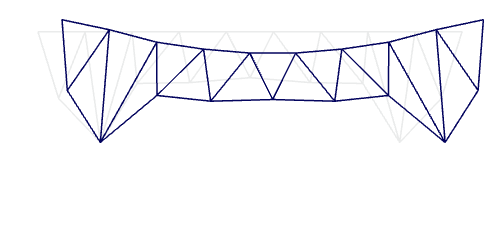

In [3]:
plotTruss(allGraphs[0], showPointLabels=False, showDeformed=True, defScale=50, showUndeformed=True, prediction=None)

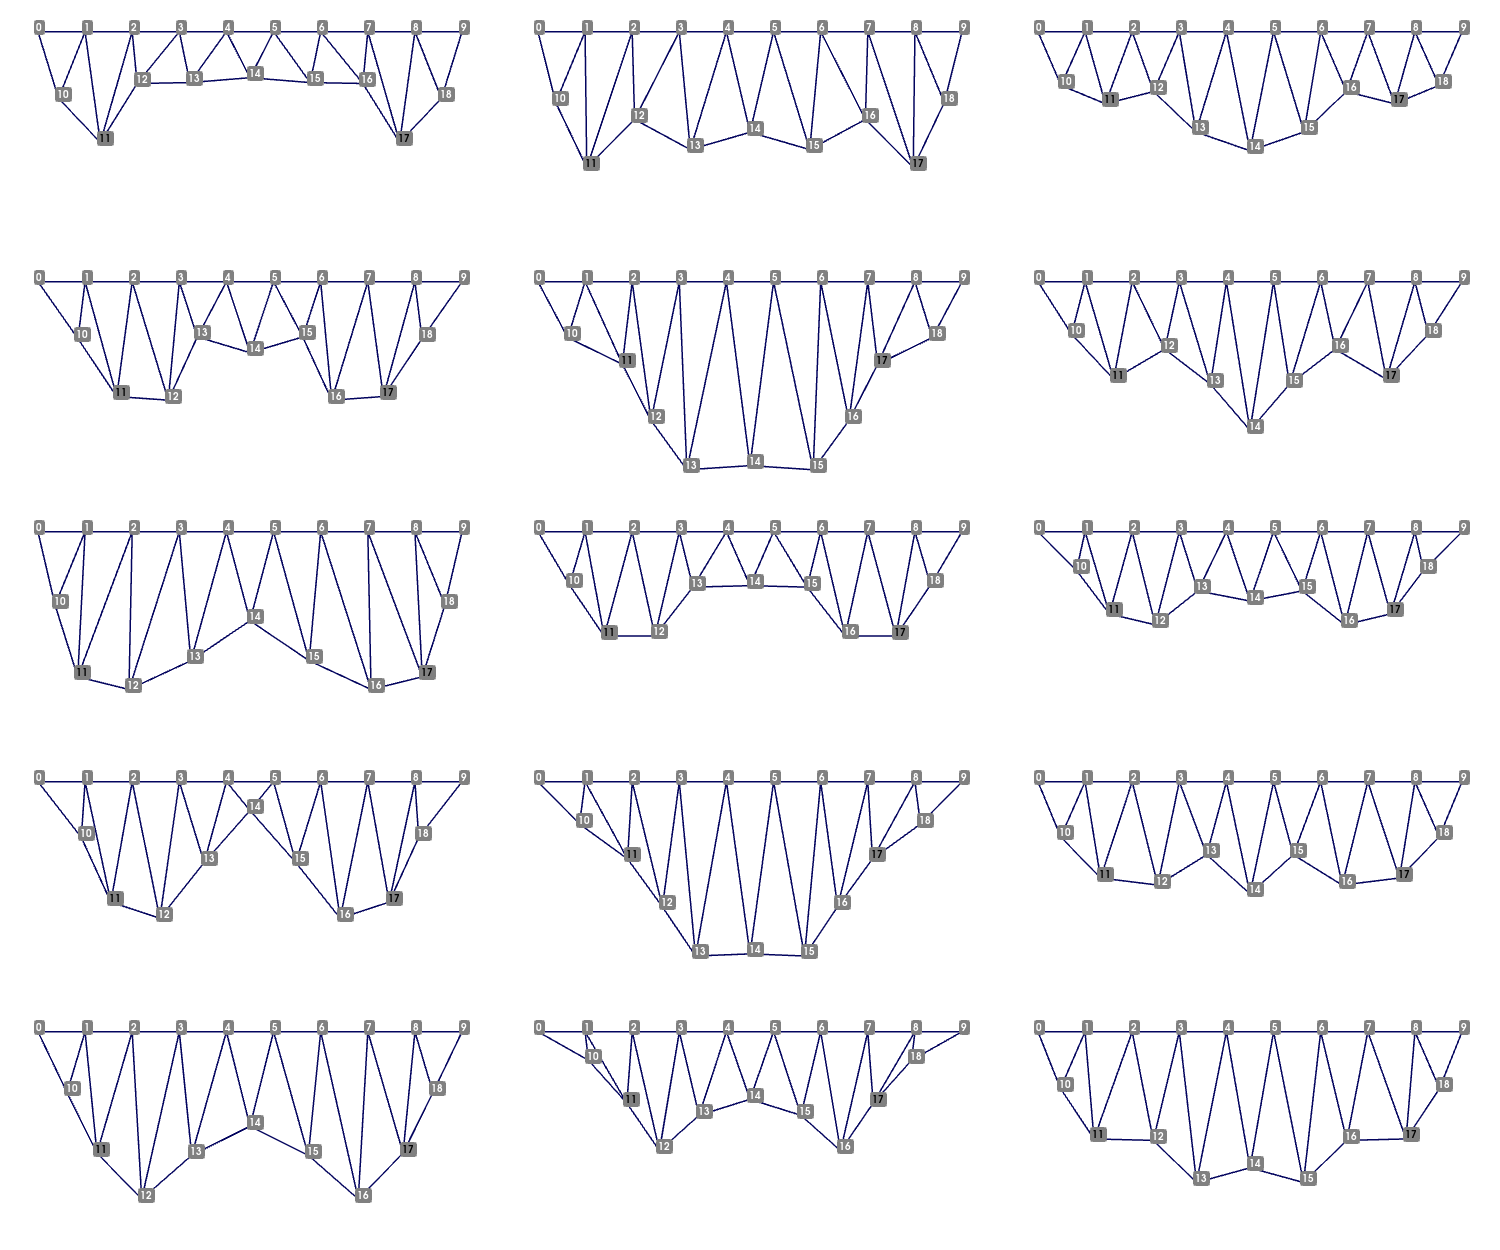

In [4]:
imgList = [plotTruss(g, screenshot=True) for g in allGraphs[:15]]
numCols = 3
numRows = int(np.ceil(len(imgList)/numCols))
h, w, _ = imgList[0].shape
tiledImg = np.empty((h*numRows, w*numCols, 4), dtype='uint8')
for row in range(numRows):
    for col in range(numCols):
        tiledImg[row*h:(row+1)*h,col*w:(col+1)*w] = imgList[row*numCols+col]
Image.fromarray(tiledImg)

## 2. Filter and transform

In [5]:
maxes = [max(np.abs(graph.y.numpy().flatten())) for graph in allGraphs]
source = pd.DataFrame(maxes, columns=['maxes'])
source.describe()

,maxes
count,10000.000000
mean,15.009532
std,1246.560325
min,0.007607
25%,0.029424
50%,0.048261
75%,0.100500
max,123269.273438


In [6]:
temp = []
for graph in allGraphs:
    if max(np.abs(graph.y.numpy().flatten())) < 1.0: temp.append(graph)
allGraphs = temp
maxes = [max(np.abs(graph.y.numpy().flatten())) for graph in allGraphs]
source = pd.DataFrame(maxes, columns=['maxes'])
source.describe()

,maxes
count,9790.000000
mean,0.084151
std,0.107889
min,0.007607
25%,0.029113
50%,0.047281
75%,0.094435
max,0.985807


In [7]:
# partition into train, validate and test
allIds = list(range(len(allGraphs)))
other, testIds = train_test_split(allIds, test_size=0.2, shuffle=True, random_state=1234) # 20% test
trainIds, valIds = train_test_split(other, test_size=0.15, shuffle=True, random_state=1234) # 15% val 15% test
trainGraphs = [allGraphs[i].clone() for i in trainIds]
valGraphs = [allGraphs[i].clone() for i in valIds]
testGraphs = [allGraphs[i].clone() for i in testIds]

# data transformations
ss = StandardScaler()

logTrans = lambda x: np.sign(x)*np.log(10.0*np.abs(x)+1.0)
invLogTrans = lambda y: np.sign(y)*(np.exp(np.abs(y))-1.0)/10.0

allResponses = np.empty((0,trainGraphs[0].y.numpy().size))
for graph in trainGraphs:
    allResponses = np.vstack([allResponses, graph.y.reshape(1,-1)])
ss.fit(allResponses)

for graph in trainGraphs+valGraphs+testGraphs:
    graph.y = torch.as_tensor(ss.transform(graph.y.reshape(1,-1)).reshape(-1,2), dtype=torch.float)
    graph.y = logTrans(graph.y)

## 3. Define model and train

In [8]:
## define network architecture
#############################################################
class FeaStNet(torch.nn.Module):
    def __init__(self):
        super(FeaStNet, self).__init__()
        self.norm0 = tg.nn.BatchNorm(4, momentum=0.3, affine=True, track_running_stats=True)
        self.lin0 = torch.nn.Linear(4, 16)
        self.conv0 = tg.nn.FeaStConv(16, 32, heads=8) # The (translation-invariant) FeaStNet convolution
        self.normc0 = tg.nn.BatchNorm(32, momentum=0.3, affine=True, track_running_stats=True)
        self.conv1 = tg.nn.FeaStConv(32, 64, heads=8)
        self.normc1 = tg.nn.BatchNorm(64, momentum=0.3, affine=True, track_running_stats=True)
        self.conv2 = tg.nn.FeaStConv(64, 128, heads=8)
        self.normc2 = tg.nn.BatchNorm(128, momentum=0.3, affine=True, track_running_stats=True)
        self.conv3 = tg.nn.FeaStConv(128, 256, heads=8)
        self.normc3 = tg.nn.BatchNorm(256, momentum=0.3, affine=True, track_running_stats=True)
        self.conv4 = tg.nn.FeaStConv(256, 128, heads=8)
        self.normc4 = tg.nn.BatchNorm(128, momentum=0.3, affine=True, track_running_stats=True)
        self.conv5 = tg.nn.FeaStConv(128, 128, heads=8)
        self.normc5 = tg.nn.BatchNorm(128, momentum=0.3, affine=True, track_running_stats=True)
        self.lin1 = torch.nn.Linear(128, 64)
        self.lin2 = torch.nn.Linear(64, 2)

    def forward(self, data):
        data.x = torch.cat([data.pos, data.x.float()], 1)
        data.x = self.norm0(data.x)
        data.x = self.lin0(data.x)
        data.x = F.relu(data.x)
        data.x = self.conv0(data.x, data.edge_index)
        data.x = self.normc0(data.x)
        data.x = F.relu(data.x)
        data.x = self.conv1(data.x, data.edge_index)
        data.x = self.normc1(data.x)
        data.x = F.relu(data.x)        
        data.x = self.conv2(data.x, data.edge_index)
        data.x = self.normc2(data.x)
        data.x = F.relu(data.x)
        data.x = self.conv3(data.x, data.edge_index)
        data.x = self.normc3(data.x)
        data.x = F.relu(data.x)
        data.x = self.conv4(data.x, data.edge_index)
        data.x = self.normc4(data.x)
        data.x = F.relu(data.x)
        data.x = self.conv5(data.x, data.edge_index)
        data.x = self.normc5(data.x)
        data.x = F.relu(data.x)
        data.x = self.lin1(data.x)
        data.x = F.relu(data.x)
        data.x = self.lin2(data.x)
        return data.x
    
# configure training
def train(model, loader, valData, device, epochs=10, saveDir=None):
    modelFile = None
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=10e-4)
    trainHist, valHist = [], []
    model.to(device)
    
    if saveDir:
        if not os.path.exists(saveDir): os.mkdir(saveDir)
    for epoch in range(epochs):

        ### train ###
        model.train()
        t = time()
        batchHist = []
        for batch in loader:
            batch.to(device)
            optimizer.zero_grad()
            out = model(batch)
            loss = F.mse_loss(out, batch.y)
            loss.backward()
            optimizer.step()
            batchHist.append(loss.item())

        trainHist.append(np.mean(batchHist))
        
        ### validate ###
        batchHist = []
        valLoader = tg.data.DataLoader(valData, batch_size=1, shuffle=False)
        model.eval()
        with torch.no_grad():
            for batch in valLoader:
                batch.to(device)
                out = model(batch)
                loss = F.mse_loss(out, batch.y)
                batchHist.append(loss.item())
        valHist.append(np.mean(batchHist))

#         if epoch%(epochs//10)==(epochs//10)-1 and epoch>0:
#             print(f'epoch: {epoch}   trainLoss: {trainHist[-1]:.4e}   time: {(time()-t):.2e}')
        print(f'epoch: {epoch}   trainLoss: {trainHist[-1]:.4e}   time: {(time()-t):.2e}')
                     
        if saveDir:
            with open(os.path.join(saveDir, 'trainlog.csv'), 'a') as fp: 
                fp.write(f'{epoch},{trainHist[-1]},{valHist[-1]},{(time()-t)}\n')
                
            if (np.argmin(valHist) == len(valHist)-1):
                modelFile = os.path.join(saveDir, f'checkpoint_{epoch}')
                torch.save(model.state_dict(), modelFile) # save best model    

    return trainHist, valHist, modelFile

def test(model, inputs, outputs, baselineRef, device, ss=None, log=None, level='set'):
    model.to(device)
    preds = []
    model.eval()
    testLoader = tg.data.DataLoader(inputs, batch_size=1, shuffle=False)
    with torch.no_grad():
        for batch in testLoader:
            batch.to(device)
            out = model(batch)
            p = out.cpu().numpy()
            if log: p = invLogTrans(p)
            if ss: p = ss.inverse_transform(p.reshape(1,-1)).reshape(-1,2)
            preds.append(p)
        
    return cu.computeFieldLossMetrics([g.y.numpy() for g in outputs], 
                                      preds, 
                                      baselineRef=[b.y.numpy() for b in baselineRef], level=level)

def predict(model, inputs, device, ss=None, log=None):
    model.to(device)
    model.eval()
    testLoader = tg.data.DataLoader(inputs, batch_size=1, shuffle=False)
    with torch.no_grad():
        for batch in testLoader:
            batch.to(device)
            out = model(batch)
            p = out.cpu().numpy()
            if log: p = invLogTrans(p)
            if ss: p = ss.inverse_transform(p.reshape(1,-1)).reshape(-1,2)
            return p

def plotHistory(trainHist, valHist):
    histDf = pd.DataFrame({'train': trainHist, 'val': valHist})
    return alt.Chart(histDf.reset_index()).transform_fold(
            ['train', 'val'],
            as_=['metric', 'value']
        ).mark_line().encode(
            alt.X('index:Q'),
            alt.Y('value:Q', axis=alt.Axis(title='loss')),
            color=alt.Color('metric:N'),
            tooltip=['epoch:Q', 'value:Q']
        ).properties(width=400, height=200)

In [9]:
# train FeaStNet
feastnet = FeaStNet()
# device = torch.device('cuda')
device = torch.device('cpu')
loader = tg.data.DataLoader(trainGraphs[:1000], batch_size=256, shuffle=True)
trainHist, valHist, modelFile = train(feastnet, loader, valGraphs[:5], device, epochs = 100, saveDir='1ktrainValTest08-local')

# load best model
bestModel = FeaStNet()
bestModel.load_state_dict(torch.load(modelFile))

# test
print(test(bestModel, 
           trainGraphs, 
           [allGraphs[i] for i in trainIds],
           [allGraphs[i] for i in trainIds], 
           device, ss=ss, log=True))
print(test(bestModel, 
           testGraphs, 
           [allGraphs[i] for i in testIds],
           [allGraphs[i] for i in trainIds], 
           device, ss=ss, log=True))
plotHistory(trainHist, valHist)

epoch: 0   trainLoss: 2.6391e+00   time: 5.04e+00
epoch: 1   trainLoss: 2.4673e+00   time: 5.09e+00
epoch: 2   trainLoss: 2.3253e+00   time: 5.05e+00
epoch: 3   trainLoss: 2.2103e+00   time: 5.17e+00
epoch: 4   trainLoss: 2.0782e+00   time: 5.23e+00
epoch: 5   trainLoss: 1.9627e+00   time: 5.31e+00
epoch: 6   trainLoss: 1.8533e+00   time: 5.40e+00
epoch: 7   trainLoss: 1.7441e+00   time: 5.40e+00
epoch: 8   trainLoss: 1.6364e+00   time: 5.37e+00
epoch: 9   trainLoss: 1.5315e+00   time: 5.48e+00
epoch: 10   trainLoss: 1.4282e+00   time: 5.38e+00
epoch: 11   trainLoss: 1.3372e+00   time: 5.47e+00
epoch: 12   trainLoss: 1.2490e+00   time: 5.41e+00
epoch: 13   trainLoss: 1.1633e+00   time: 5.43e+00
epoch: 14   trainLoss: 1.0910e+00   time: 5.55e+00
epoch: 15   trainLoss: 1.0270e+00   time: 5.79e+00
epoch: 16   trainLoss: 9.5892e-01   time: 5.58e+00
epoch: 17   trainLoss: 9.0478e-01   time: 5.45e+00
epoch: 18   trainLoss: 8.6517e-01   time: 5.48e+00
epoch: 19   trainLoss: 8.1736e-01   time:

alt.Chart(...)

## 4. Visualize some predictions

In [10]:
testFieldMetrics = test(bestModel, 
                       testGraphs, 
                       [allGraphs[i] for i in testIds],
                       [allGraphs[i] for i in trainIds], 
                       device, ss=ss, log=True, level='field')

In [12]:
df = pd.DataFrame(testFieldMetrics)
df['rank'] = df['mse'].rank()
df = df.sort_values('rank')
df['percentile'] = df['mse'].rank(pct=True)
# df[df.percentile>.9]
df

,mse,mae,mre,maxAE,mae/peak,maxAE/peak,relEAtPeak,rank,percentile
1455,0.000005,0.001737,0.088679,0.005611,0.083682,0.270361,0.220006,1.0,0.000511
1683,0.000005,0.001748,0.095047,0.006449,0.099256,0.366278,0.154473,2.0,0.001021
512,0.000006,0.001809,0.088439,0.006929,0.057573,0.220475,0.015525,3.0,0.001532
1783,0.000007,0.002184,0.130642,0.005131,0.114281,0.268510,0.196301,4.0,0.002043
506,0.000007,0.001959,0.100816,0.006877,0.065888,0.231287,0.088313,5.0,0.002554
...,...,...,...,...,...,...,...,...,...
1140,0.065530,0.202141,0.609839,0.660402,0.229463,0.749663,0.736649,1954.0,0.997957
1129,0.094034,0.273631,0.782667,0.548429,0.330708,0.662826,0.603135,1955.0,0.998468
1788,0.114827,0.290018,0.863296,0.740847,0.333338,0.851507,0.551926,1956.0,0.998979
1871,0.115113,0.297833,0.912263,0.765050,0.380988,0.978651,0.872775,1957.0,0.999489


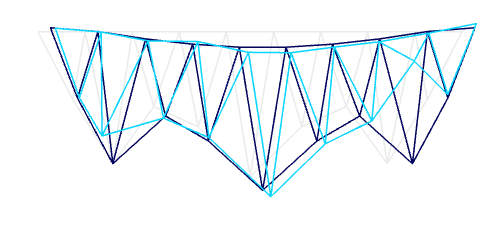

In [22]:
i=10
graph = allGraphs[testIds[i]]
pred = predict(bestModel, [graph], device, ss=ss, log=True)
plotTruss(graph, showPointLabels=False, showDeformed=True, defScale=100, showUndeformed=True, prediction=pred)

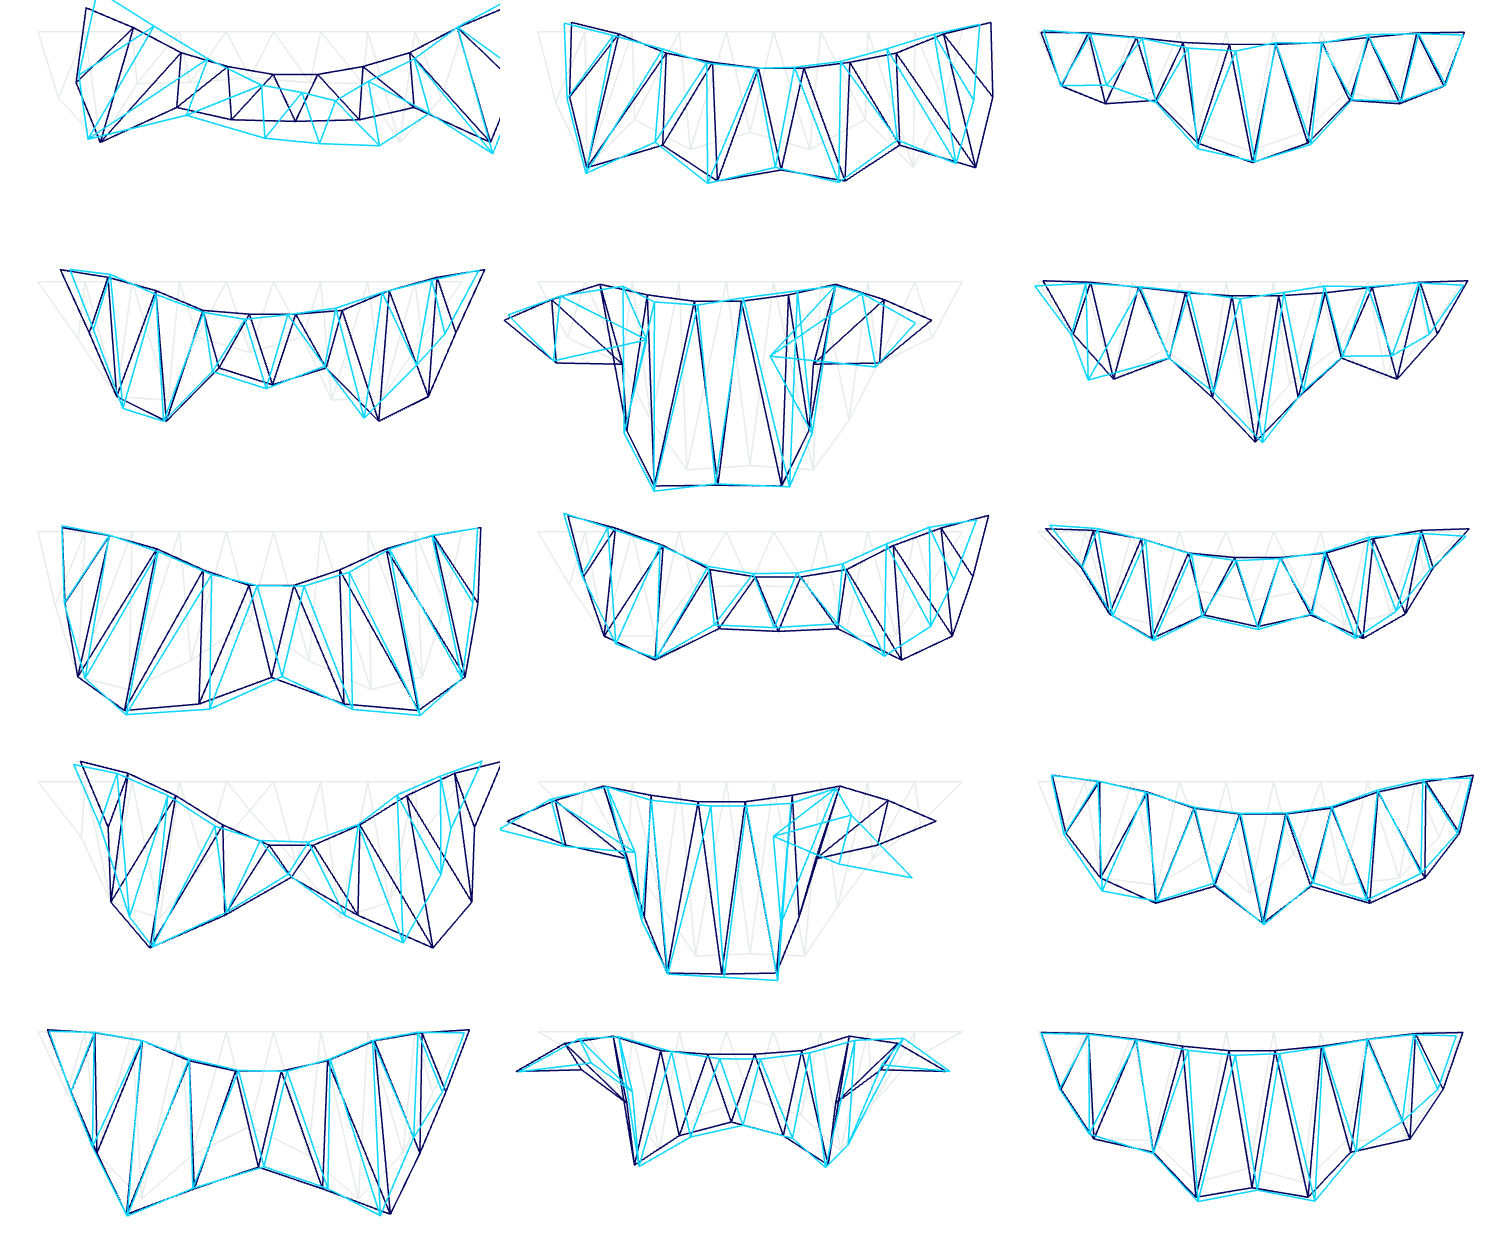

In [24]:
predList = [predict(bestModel, [g], device, ss=ss, log=True) for g in allGraphs[:15]]
imgList = [plotTruss(g, screenshot=True, showPointLabels=False, showDeformed=True, defScale=100, showUndeformed=True, prediction=p) for g,p in zip(allGraphs[:15], predList)]
numCols = 3
numRows = int(np.ceil(len(imgList)/numCols))
h, w, _ = imgList[0].shape
tiledImg = np.empty((h*numRows, w*numCols, 4), dtype='uint8')
for row in range(numRows):
    for col in range(numCols):
        tiledImg[row*h:(row+1)*h,col*w:(col+1)*w] = imgList[row*numCols+col]
Image.fromarray(tiledImg)